### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [2]:
ETF_NAME = 'CERN'
ETF_DIRECTORY = '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/'

df = pd.read_csv(os.path.join(ETF_DIRECTORY, ETF_NAME.lower() + '.us.txt'), sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-01-04,20.940,21.103,20.713,21.068,3058908,0
1,2010-01-05,21.355,22.345,21.250,22.313,7324724,0
2,2010-01-06,22.500,22.873,22.265,22.548,6844460,0
3,2010-01-07,22.423,22.750,22.230,22.680,2968936,0
4,2010-01-08,22.578,22.663,22.345,22.633,3238372,0


### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [3]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

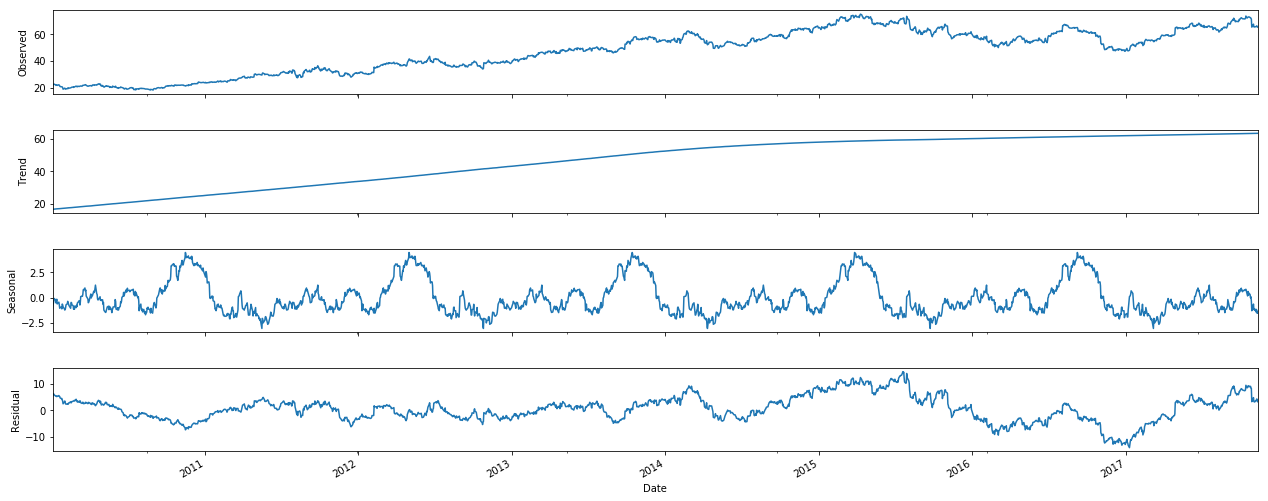

In [4]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [5]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [6]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [7]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [8]:
df['Close'] = df['Close'].shift(-1)

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [9]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [10]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [11]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

### Split into features and labels

In [12]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 8 columns):
EMA_9          1362 non-null float64
SMA_5          1362 non-null float64
SMA_10         1362 non-null float64
SMA_15         1362 non-null float64
SMA_30         1362 non-null float64
RSI            1362 non-null float64
MACD           1362 non-null float64
MACD_signal    1362 non-null float64
dtypes: float64(8)
memory usage: 85.2 KB


### Fine-tune XGBoostRegressor

In [13]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 400, 'random_state': 42}
Best validation score = -1.2270088082025257
CPU times: user 4min 28s, sys: 3.69 s, total: 4min 32s
Wall time: 4min 32s


In [14]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 1.7 s, sys: 9.98 ms, total: 1.71 s
Wall time: 1.71 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

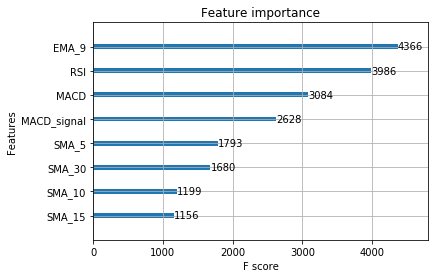

In [15]:
plot_importance(model);

### Calculate and visualize predictions

In [16]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [61.48 62.11 62.37 62.98 62.75]
y_pred = [62.9743   62.52874  62.888466 63.106403 63.08649 ]


In [17]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 2.885970142099009


In [18]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()